aggiungere https://www.istat.it/it/metodi-e-strumenti/web-service-sdmx

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit

def scale(x, sf):
    global scalepars_min_x, scalepars_max_xp
    scalepars_min_x = np.min(x)
    x_sc = x-scalepars_min_x
    scalepars_max_xp = np.max(x_sc)
    x_sc = x_sc/scalepars_max_xp
    x_sc *=sf
    return x_sc

def scale_back(x, sf):
    global scalepars_min_x, scalepars_max_xp
    
    x_sc = x/sf
    x_sc *= scalepars_max_xp
    x_sc = x_sc+scalepars_min_x
    return x_sc

def calc_sq_diff(a, b):
    return np.sum(np.square(a-b))

## Studio redditi dichiarati

In [22]:
# file preso da https://www1.finanze.gov.it/finanze3/analisi_stat/index.php?tree=2018AAPFTOT020602&export=0&media=media&page=1&personalizza=no
df = pd.read_csv("irpef2.csv", delimiter=";", decimal=",", thousands=".")


In [23]:
def calc_vc(val):

    val_sep = val.split("-")
    vc = (int(val_sep[1]) - int(val_sep[0]))/2 + int(val_sep[0])
    return vc
df["valore_centrale"] = df['Codice'].apply(calc_vc)

def calc_larg(val):

    val_sep = val.split("-")
    l = (int(val_sep[1]) - int(val_sep[0]))
    return l
df["larghezza"] = df['Codice'].apply(calc_larg)
df = df[df['valore_centrale']<100000]

In [24]:
df['area_loc'] = df["larghezza"]* df["Reddito complessivo - Ammontare"]
area_tot = np.sum(df['area_loc'])
area_tot

4200438836500

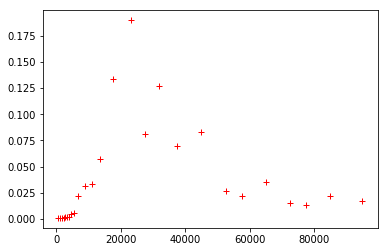

In [25]:
y_norm =  df["Reddito complessivo - Ammontare"]/area_tot
plt.plot(df['valore_centrale'], y_norm/np.sum(y_norm), 'r+')

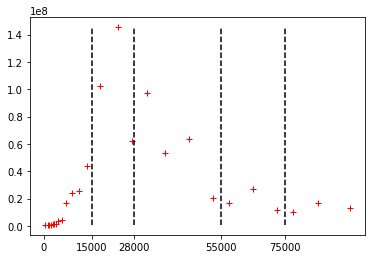

In [26]:
y4plot = df["Reddito complessivo - Ammontare"]#/1e8+2
plt.plot(df['valore_centrale'], y4plot, 'r+')

max_y = np.max(y4plot)
min_y = np.min(y4plot)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')

/Users/vincenzo/miniconda3/envs/py37.3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/vincenzo/miniconda3/envs/py37.3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1410: RuntimeWarning: overflow encountered in multiply
  return 0.5 * invK * expval * sc.erfc(-(x - invK) / np.sqrt(2))
/Users/vincenzo/miniconda3/envs/py37.3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:1410: RuntimeWarning: invalid value encountered in multiply
  return 0.5 * invK * expval * sc.erfc(-(x - invK) / np.sqrt(2))


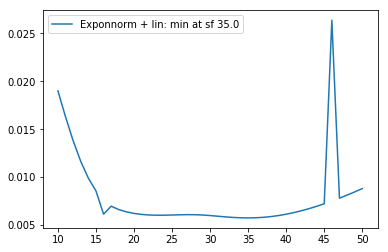

minimo in pos 25: scalato a 35.0 , valore: 0.005731732382224454


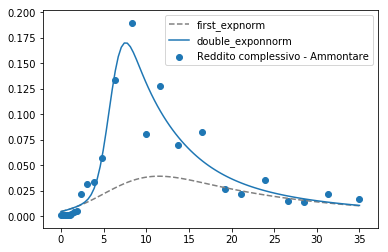

In [9]:
def double_exponnorm(x, p0, p1, p2, p3):
    return stats.exponnorm.pdf(x,  p0, p1, p2) + stats.exponnorm.pdf(x,  p0, p1, p3)

rescaled = np.linspace (10, 50, 41)

sq_errs = []
y2use = y_norm/np.sum(y_norm)
last = 100
tutti_pars = []
for sf in rescaled:
    x_sc = scale(df['valore_centrale'], sf)
    initial = [5, 3, 0.8, 0.4]
    try:
        pars, cov = curve_fit(double_exponnorm, x_sc, y2use, p0 = initial)#, bounds=bounds)
        tutti_pars .append(pars)
        sq_err = calc_sq_diff(double_exponnorm(x_sc, pars[0], pars[1], pars[2], pars[3]), y2use)
        sq_errs.append(sq_err)
        last = sq_err
    except RuntimeError:
        sq_errs.append(last)
min_at=np.argmin(sq_errs)
sf_scelto = rescaled[min_at]
errore = sq_errs[min_at]
pars_scelti = tutti_pars[min_at]

plt.plot(rescaled, sq_errs, label = f"Exponnorm + lin: min at sf {sf_scelto}")
plt.legend()
plt.show()


print (f"minimo in pos {min_at}: scalato a {sf_scelto} , valore: {errore}")

xt = np.linspace(0, sf_scelto, 100)
y1 = stats.exponnorm.pdf(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2])
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt, y1, '--', label='first_expnorm', color = 'grey')
plt.plot(xt, yt, label="double_exponnorm")

x_sc = scale(df['valore_centrale'], sf_scelto)
plt.scatter(x_sc, y2use)
plt.legend()
plt.show()



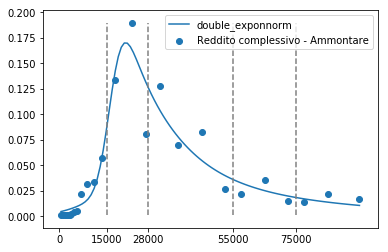

In [10]:

xt = np.linspace(0, sf_scelto, 100)
xt_sc_b = scale_back(xt, sf_scelto)
yt = double_exponnorm(xt, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])

plt.plot(xt_sc_b, yt, label="double_exponnorm")

x_sc = scale(df['valore_centrale'], sf_scelto)
plt.scatter(df['valore_centrale'], y2use)
plt.legend()
max_y = np.max(y2use)
min_y = np.min(y2use)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'gray')
plt.show()

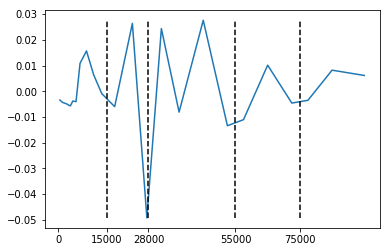

In [11]:
pars_scelti = np.array([3.69957129, 5.87470515, 4.25561841, 1.2146135 ])

baseline =  double_exponnorm(x_sc, pars_scelti[0], pars_scelti[1], pars_scelti[2], pars_scelti[3])
dati_m_baseline = y2use - baseline
x_sc_b = scale_back(x_sc, 35)
plt.plot(x_sc_b, dati_m_baseline)
max_y = np.max(dati_m_baseline)
min_y = np.min(dati_m_baseline)
plt.xticks(scaglioni)
for s in scaglioni:
    if s == 0:
        continue
    plt.plot([s, s], [min_y, max_y], '--', color = 'k')
plt.show()

## da scaglioni a continua

In [28]:
no_tax = 8174
scaglioni = np.array([ 0, 15000, 28000, 55000, 75000])
aliquote = np.array([ .23, .27, .38, .41, .43])
base = np.array([ 0, 3450, 6960, 17220, 25420])

def calc_irpef(reddito):
    if reddito <= no_tax:
        return 0
    
    for i_s, s in enumerate( scaglioni):
        b = base[i_s-1]
        a = aliquote[i_s-1]
        if reddito > s:
            continue
            
        else:
            #print ("reddito", reddito, "scaglione", s, "aliquota", a, "base", b, "sttraggo", scaglioni[i_s-1])
            return  b + a * (reddito - scaglioni[i_s-1])
    return base[-1] + aliquote[-1] * (reddito - scaglioni[-1])

            
        
calc_irpef(15001)

3450.27

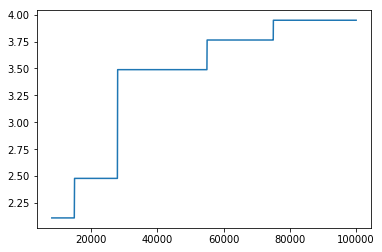

In [29]:
x=np.linspace(8200, 100000, 10000)
y= []
for x_i in x:
    y.append(calc_irpef(x_i))
    

yp = np.gradient(y)
plt.plot(x, yp)
plt.show()

parametri [-6.00955903e+04  2.41585815e+01  4.56266693e-01]


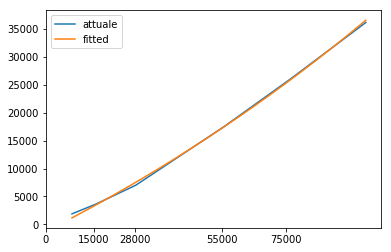

In [30]:
def fit_tax(x, p0, p1, p2):
    return p0+np.exp((x+p1)*p2)

x_sc = scale(x, 1)

pars, covs = curve_fit(fit_tax, x_sc, y)
print('parametri', pars)

plt.plot(x, y, label='attuale')
y_fit = fit_tax(x_sc, *pars)
plt.plot(x, y_fit, label="fitted")
plt.xticks(scaglioni)

plt.legend()

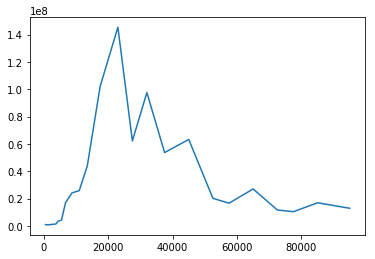

In [27]:
# attuale metodo: stima totale irpef

#plt.plot(df['valore_centrale'], df["Reddito complessivo - Ammontare"])
